# Validation of Data Extraction from netcdf Files
A single netcdf file represents one 3 hour period of a single day. Every netcdf file contains PC-TAU data in the form of gridboxes -- PC-TAU histograms that cover a certain area of the Earth (1 degree by 1 degree in the case of the HGG dataset). 

Basic descriptions of the variables below can be found [here](https://www.ncdc.noaa.gov/sites/default/files/ISCCPBasicvs.Full-Description.pdf).

The variables are matricies with various shapes. Here are brief descriptions of the variables used:
+ `pctaudist` is a collection of `41252` gridboxes (PC-TAU Histograms). This is arranged in Equal-Area format -- a transformation to Equal-Angle will be made. Each gridbox is a (6, 7) arrangement of pixels with each value in the histogram representing the counts made by that specific pixel. 

+ `sqlon_beg`,`sqlon_end`, and `eqlat` are used to transform data to Equal-Angle. The algorithim used is found in the metadata of the netcdf file but can be found below:

    * TO RE-MAP EQUAL-AREA MAP TO EQUAL-ANGLE (SQUARE LON,LAT) MAP ---------- For display purposes, the ISCCP equal-area map may be converted to an equal-angle map using replication. The variables 'eqlat_index', 'sqlon_beg' and 'sqlon_end'are provided for this purpose. Each equal-area cell is replicated into a specific range of longitude cells in the equal-angle map. For example, to remap an equal-area array eqvar[41252] to an equal-angle array sqmap[360,180], each eqvar[i] should be replicated into the range of cells indicated by sqlon_beg[i] and sqlon_end[i], and the lat index eqlat_index[i]. Using Fortran notation the assignment is: sqmap[sqlon_beg[i]:sqlon_end[i], eqlat_index[i]] = eqvar[i].


+ `n_total` contains the total pixel counts for each gridbox. It is used to convert the data (`pctaudist`) from pixel counts to percentages via division. 

In [154]:
import os
import math
import time
import netCDF4
import analysispy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib

In [176]:
basepath = '/run/media/dtropf/Seagate Backup Plus Drive/hgg_data/2000/ISCCP_HSeries_HGG_v01r00_200002_c20170323/'
filename = 'ISCCP.HGG.v01r00.GLOBAL.2000.02.25.0000.GPC.10KM.CS00.EQ1.00.nc'
path = basepath+filename
data = netCDF4.Dataset(path)
pctaudist = data['n_pctaudist'][:,:,:]
sqlonbeg = data['sqlon_beg'][:]
sqlonend = data['sqlon_end'][:]
eqlat = data['eqlat_index'][:]
ntotal = data['n_total'][:]
temp = data['tmax'][:]
print(pctaudist.shape, sqlonbeg.shape, sqlonend.shape, eqlat.shape, ntotal.shape, temp.shape)

(6, 7, 41252) (41252,) (41252,) (41252,) (41252,) (41252,)


This map of temperature is created to demonstrate the algorithm for converting from Equal-Area to Equal-Angle.

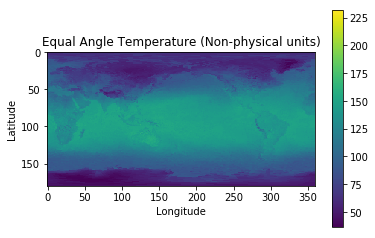

In [177]:
temp_map = np.zeros((360, 180))
for i in range(temp.shape[0]):
    # Algorithm above is Fortran, must include '-1' for Python since starting index is 0.
    temp_map[sqlonbeg[i]-1:sqlonend[i], eqlat[i]-1] = temp[i]
fig, ax = plt.subplots()
im = ax.imshow(np.rot90(temp_map))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Equal Angle Temperature (Non-physical units)')
fig.colorbar(im)
plt.show()

# Computing Weather State

The goal is to determine the weather state each gridbox corresponds to. To do this:
1. Loop over every gridbox in pctaudist
2. For each gridbox, compute the euclidean distance against each weather state
3. The smallest distance determines the weather state

An empty matrix, `grid_boxes`, of shape (360, 180, 12) is made to keep track of the weather state of each gridbox in an Equal-Area format. 

As an example, suppose the $i^{th}$ gridbox is found to be in weather state 5. The appropriate cells in `grid_boxes` are then incremented to keep track of the gridboxes that are weather state 5. The appropriate cells are determined by `sqlon_beg`,`sqlon_end`, `eqlat`, and the weather state number. 

The specific cells in this scenario are (in Python) `grid_boxes[sqlon_beg[i]-1:sqlon_end[i], eqlat[i]-1, weather_state] += 1`.

This shows that `grid_boxes` should be thought of as 12 Equal-Area maps, each of which corresponds to a specific weather state. Each of these maps represent the same gridboxes and counts how many times a gridbox has been found to be in a specific weather state.

## Computing Weather State in Python

The weather state for each gridbox is computed in the Python code below.

In [178]:
# Computing Euclidian distance between grid_box and all PC-TAU weather state histograms
def compute_distance(grid_box, pctau_list):
    distances = []
    for i in range(pctau_list.shape[0]):
        # Euclidean distance
        distances.append(np.sqrt(np.sum(np.square((grid_box-pctau_list[i,:,:])))))
    return distances

# Load weather state data and reshape it to match pctaudist data
# Also divide by 100 to convert to percentage
pctau_list = np.loadtxt(os.getcwd()+'/'+'pctau.txt').reshape(12, 7, 6).transpose((0,2,1))/100.0

# Compute the weather state for each gridbox.
# Not all gridboxes collected data (because it was night during data collection most likely)
# These gridboxes are skipped and not taken into account
t1 = time.time()
py_gridboxes = np.ma.zeros((360, 180, 12))
py_gridboxes.mask = False

# Loop over every gridbox in pctaudist
for i in range(pctaudist.shape[2]):
    # Check if the gridbox should be skipped (no data collected)
    if np.all(pctaudist.mask[:,:,i]):
        continue
    pctau_data = pctaudist[:,:,i]/ntotal[i]
    
    # Compute Euclidean distances
    distances = compute_distance(pctau_data, pctau_list)
    
    # Choose weather state with smallest distance
    weather_state = distances.index(min(distances))
    py_gridboxes[sqlonbeg[i]-1:sqlonend[i], eqlat[i]-1, weather_state] += 1
t2 = time.time()
print('Run time in seconds: ', t2-t1)

Run time in seconds:  19.526314735412598


# Computing Weather State in Fortran

One netcdf file is, again, a three hour period for a single day. Determining weather states for every gridbox in Python takes roughly 20 seconds for one netcdf file. This is far too slow considering there are 20+ years of data. Below is the same analysis, however in Fortran.

In [179]:
# The Fortran code is converted to Python using f2py. The corresponding functions are
# imported from analysispy
t1 = time.time()
# Normalize all data (convert to percentage)
pctaudist_norm = analysispy.fnorm(pctaudist, ntotal, pctaudist.mask)
# Find weather state for each gridbox
ws_num, ws_total = analysispy.findws(pctaudist_norm, pctau_list, pctaudist.mask, sqlonbeg, sqlonend, eqlat)
t2 = time.time()
print('Run time in seconds: ', t2-t1)

Run time in seconds:  0.03873038291931152


# Comparing Python and Fortran

Clearly Fortran is substantially faster -- however, it must be shown that the results from both methodologies are the same.

20079 20079.0 0.0


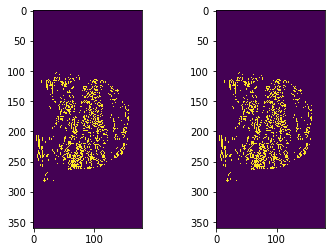

In [180]:
# The total counts should be equal and the difference between the two should be zero
print(np.sum(ws_num), np.sum(py_gridboxes), np.sum(py_gridboxes-ws_num))

# The same exact plot should be made using either
fig, axes = plt.subplots(ncols=2)
axes[0].imshow(py_gridboxes[:,:,6], interpolation='none')
axes[1].imshow(ws_num[:,:,6], interpolation='none')

In [181]:
# Keep this block for now as a test area to show that certain things do indeed work
# For feb 5 2000
print(pctaudist[:,:,500])
pctaudist.mask[1,1,500] = True
print(pctaudist[:,:,500])
print(pctaudist[:,:,501])
print('difference array')
print(pctaudist[:,:,500]-pctaudist[:,:,501])
print('euclidian distance', np.sqrt(np.sum(np.square((pctaudist[:,:,500]-pctaudist[:,:,501])))))
print('euclidian distance with numpy', np.sqrt(np.sum(np.square(np.subtract(pctaudist[:,:,500],pctaudist[:,:,501])))))
print(ntotal[500], np.sum(pctaudist[:,:,500]/ntotal[500]), np.sum(pctau_list[9,:,:]))
print(pctaudist[:,:,500]/ntotal[500])
print(np.sqrt(np.sum(np.square((pctaudist[:,:,500]-pctau_list[9,:,:])))))
print(np.sqrt(np.sum(np.square(np.where(pctaudist.mask[:,:,500],0, pctaudist[:,:,500]-pctau_list[9,:,:])))))

[[0 0 9 0 0 3 0]
 [0 0 1 2 0 1 0]
 [0 0 1 1 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 2 2 3 0 0]
 [0 1 15 13 8 0 0]]
[[0 0 9 0 0 3 0]
 [0 -- 1 2 0 1 0]
 [0 0 1 1 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 2 2 3 0 0]
 [0 1 15 13 8 0 0]]
[[0 8 1 0 0 0 0]
 [0 9 5 0 0 1 0]
 [0 37 1 0 1 0 0]
 [0 13 6 2 1 0 0]
 [0 10 2 0 3 1 0]
 [0 29 6 4 3 1 0]]
difference array
[[0 -8 8 0 0 3 0]
 [0 -- -4 2 0 0 0]
 [0 -37 0 1 -1 1 0]
 [0 -13 -6 -2 -1 1 0]
 [0 -10 0 2 0 -1 0]
 [0 -28 9 9 5 -1 0]]
euclidian distance 53.075418038862395
euclidian distance with numpy 53.075418038862395
144 0.4444444444444444 0.830866087098
[[0.0 0.0 0.0625 0.0 0.0 0.020833333333333332 0.0]
 [0.0 -- 0.006944444444444444 0.013888888888888888 0.0
  0.006944444444444444 0.0]
 [0.0 0.0 0.006944444444444444 0.006944444444444444 0.0
  0.006944444444444444 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.006944444444444444 0.0]
 [0.0 0.0 0.013888888888888888 0.013888888888888888 0.020833333333333332
  0.0 0.0]
 [0.0 0.006944444444444444 0.10416666666666667 0.09027777777777778
  0

In [173]:
path = '/run/media/dtropf/Seagate Backup Plus Drive/hgg_data/2000/ISCCP_HSeries_HGG_v01r00_200002_c20170323/'
files = [path+file for file in sorted(os.listdir(path))]
for file in files:
    with netCDF4.Dataset(file) as data:
        pctaudist = data['n_pctaudist'][:,:,:]
        for i in range(pctaudist.shape[2]):
            if not np.all(pctaudist.mask[:,:,i]):
                #print('prior',i)
                if np.any(pctaudist.mask[:,:,i]):
                    print(i)

In [194]:
basepath = '/run/media/dtropf/Seagate Backup Plus Drive/hgg_data/2000/ISCCP_HSeries_HGG_v01r00_200002_c20170323/'
filename = 'ISCCP.HGG.v01r00.GLOBAL.2000.02.25.1800.GPC.10KM.CS00.EQ1.00.nc'
path = basepath+filename
data = netCDF4.Dataset(path)
pctaudist = data['n_pctaudist'][:,:,:]